# Project BBT045
Question:
> How pharmaceutical pollution affect microbial community composition

In [1]:
#Load modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib


# Temporary

In [2]:
# Directories
# groupDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/
# resultsDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/
# dataDirectory = /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA


# Checking stuff, remove later

##Check that we have access to the files in the common directory:
#with open("/cephyr/NOBACKUP/groups/bbt045_2024/project_group1/filelist.txt") as f: # The with keyword automatically closes the file when you are done
#    print(f.read())
#    #ref https://stackoverflow.com/questions/18256363/how-do-i-print-the-content-of-a-txt-file-in-python

#Search for packages in the softwarelist
! grep "meta" < /cephyr/NOBACKUP/groups/bbt045_2024/ProjectSoftware/bbt045-projects.yml

# Display the files in the data directory
#!ls {dataDirectory}

# Check variable directory names
#!head {dataDirectory}/change_filenames_1.sh

  - importlib-metadata=7.0.1=py310h06a4308_0
  - importlib_metadata=7.0.1=hd3eb1b0_0
  - metaphlan=4.0.6=pyhca03a8a_0


In [3]:
%%bash
DATADIR=/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA;

# Test av loop och filsökning med *:
for file in `ls $DATADIR/*_1.fastq.gz  | grep -v "_lake_" | sed "s/_1.fastq.gz//"`
do
    echo $file
    #outputName=`echo $file | sed "s/\/cephyr\/NOBACKUP\/groups\/bbt045_2024\/PROJECT_DATA\///"`
    #echo $outputName
done

/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_1.5km_2012
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_17.5km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_2.3km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/downstream_2.7km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/effluent_point_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_1.9km_2011
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_150m_2012
/cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/upstream_2.2km_2011


# TO DO
- Text hur vi valde saker
- Text hur vi valde inställningar
- Referenser: manualer?
- Länk till script-filer? Fungerar det i Jupyter?
- Uppdatera text med hur scriptet körs?
- Ta bort onödiga kommentarer i kodrutorna
- Fixa rescaled values
- PCA plot i jupyter?
- Andra plots i jupyter? Barplots? Boxplots?
- Count species per sample?


# Quality control and trimming

## FastQC
Do FastQC for all samples except those with "lake" in their name. 

In [4]:
%%script false --no-raise-error
for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/*.fastq.gz | grep -v "_lake_"`
do
    fastqc $file -o /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/fastqc
done

#Tekniskt sett är det detta som körs:
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done

## Bash script for trimmomatic

The following sbatch script is to run trimmomatic on all samples except those with "_lake_" in their name

NOTE:
- [Trimmomatic script 2011](sbatch_files/sbatch_trimmomatic_2011.sh) <-- Test av länk till fil
- [Trimmomatic script 2012](sbatch_files/sbatch_trimmomatic_2012.sh)
- Only difference is what files are copied in and `-phred64` in 2011, `-phred33`in 2012 #todo

Paired End Mode:
ref: http://www.usadellab.org/cms/?page=trimmomatic
> trimmomatic PE [-threads <threads>] [-phred33 | -phred64] [-trimlog <logFile>] <input 1> <input 2> <paired output 1> <unpaired output 1> <paired output 2> <unpaired output 2> <step 1> ...

In [5]:
%%script false --no-raise-error
### Running Trimmomatic
for file in `ls *_1.fastq.gz  | grep -v "_lake_" | sed "s/_1.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC trimmomatic PE -phred64 \
                    $file\_1.fastq.gz $file\_2.fastq.gz \
                    $file\_1.trimmed.fastq.gz $file\_1.un.trimmed.fastq.gz \
                    $file\_2.trimmed.fastq.gz $file\_2.un.trimmed.fastq.gz \
                    TOPHRED33 \
                    LEADING:30 TRAILING:30 \
                    MINLEN:60
done

# FastQC (again)
Körde fastqc igen, fast denna gång på alla filer i project_group1/results/trimmomatic/

In [6]:
%%script false --no-raise-error
for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/PROJECT_DATA/*.fastq.gz | grep -v "_lake_"`
do
    fastqc $file -o /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/fastqc
done

#todo Tekniskt sett är det detta som körs:
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done
#todo Remove?

# Metaphlan4

Running metaphlan4

Wiki: https://github.com/biobakery/biobakery/wiki/metaphlan4 

In [7]:
%%script false --no-raise-error
#run the following in a terminal in a new tab in jupyter:
metaphlan -h | less
#todo Remove

In [8]:
%%script false --no-raise-error
for file in `ls *1.trimmed.fastq.gz | sed "s/_1.trimmed.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC \
        metaphlan $file\_1.trimmed.fastq.gz,$file\_2.trimmed.fastq.gz \
                --input_type fastq --nproc 16 --unclassified_estimation \
                --bowtie2out $file.bowtie2.bz2 -o $file\_profile.txt\
                                            
done

# Visualizing metaphlan output

## Creating clean files

In [9]:
%%script false --no-raise-error
# Merge the _profile tables for each sample into a single file
!merge_metaphlan_tables.py /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/metaphlan/*_profile.txt > merged_abundance_table.txt
#ref: https://github.com/biobakery/biobakery/wiki/metaphlan4#16-merging-metaphlan-profiles

# Isolate the species-resolved rows and then remove clutter 
!grep -E "s__|clade_name|UNCLASSIFIED" merged_abundance_table.txt |\
    grep -v "t__" |\
    sed "s/^.*|s__//g" |\
    > merged_abundance_table_species.txt
#ref https://github.com/biobakery/biobakery/wiki/metaphlan4#211-generate-a-species-only-abundance-table

#remove s__ to keep it in the file, for specificity?
#todo förbättra kommentarer ovan, se ref:s för mer info

In [10]:
%%script false --no-raise-error
%%bash
#Calclulate the number of species in each file and save in a new file, to be used for a dataframe later.
echo -e "Sample\tspecies_count\ttype\tyear\tread_amount" > species_count.txt #Header row

for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/metaphlan/*_profile.txt`
do
name=`echo $file | sed "s/.*\///" | sed "s/_201[12]_profile.txt//"`
count=`grep "s__" $file | grep -cv "t__"`
type=`echo $name | sed "s/_.*//"`
year=`echo $file | sed "s/.*\///" | cut -d "_" -f 3`
readAmount=`grep "reads processed" $file | tr -d "[a-z#]"`
echo -e "$name\t$count\t$type\t$year\t$readAmount" >> species_count.txt
done

## Create Dataframes

In [11]:
species_file = "merged_abundance_table_species.txt"

# Tab separated, first row column names, first column row names
species_df = pd.read_csv(species_file, sep='\t', header=0, index_col=0)

# Calculate the unclassified proportion
unclassified__proportion = species_df.iloc[0,:]
print("Unclassified proportion:")
print(unclassified__proportion)

# Divide the calculated value for each column
species_scaled_df = species_df.div((100-unclassified__proportion)/100)
species_scaled_df = species_scaled_df.drop("UNCLASSIFIED")

# Transpose the dataframe 
species_scaled_df = pd.DataFrame.transpose(species_scaled_df)

species_scaled_df

Unclassified proportion:
downstream_1.5km_2012     92.60910
downstream_17.5km_2011    98.59995
downstream_2.3km_2011     97.33405
downstream_2.7km_2011     98.11041
effluent_point_2011       96.75502
upstream_1.9km_2011       98.16720
upstream_150m_2012        88.27704
upstream_2.2km_2011       94.85458
Name: UNCLASSIFIED, dtype: float64


clade_name,Planktothricoides_sp_FACHB_1261,Aliarcobacter_cryaerophilus,GGB41707_SGB58791,Methylomonas_sp_MP1,GGB41812_SGB58908,GGB27265_SGB75289,GGB74951_SGB62012,GGB75611_SGB103138,Alishewanella_agri,Candidatus_Nitrotoga_fabula,...,Atlantibacter_hermannii,Caenibius_sp_WL,Gemmobacter_lanyuensis,GGB61845_SGB83974,Geomonas_ferrireducens,Mesorhizobium_sp_YM1C_6_2,GGB42747_SGB59953,Anaeroarcus_burkinensis,Aurantimicrobium_minutum,Zoogloea_ramigera
downstream_1.5km_2012,67.567794,7.019982,6.477832,2.410221,2.113971,1.238690,1.07034,1.04439,1.00893,0.75544,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
downstream_17.5km_2011,0.000000,2.471096,0.099680,1.569674,48.286468,1.354163,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
downstream_2.3km_2011,0.027040,1.490232,3.068874,0.051750,66.248143,1.297672,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
downstream_2.7km_2011,0.919350,6.555089,1.032720,0.104990,48.314722,0.778760,0.00000,0.00000,0.11196,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
effluent_point_2011,0.483759,9.618679,3.224156,0.553019,33.562431,1.454458,0.00000,0.09031,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
upstream_1.9km_2011,1.805045,11.545031,0.122590,0.026520,0.035430,0.153550,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
upstream_150m_2012,78.131502,4.801341,0.507670,1.206730,0.000000,0.044830,0.00000,0.28366,0.07936,0.00000,...,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
upstream_2.2km_2011,0.300850,9.190286,5.645158,0.766860,0.037960,1.922469,0.00000,0.07625,0.00000,0.00000,...,0.02624,0.02554,0.0191,0.01848,0.01598,0.01501,0.01289,0.01143,0.00741,0.00712


In [12]:
#ref: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

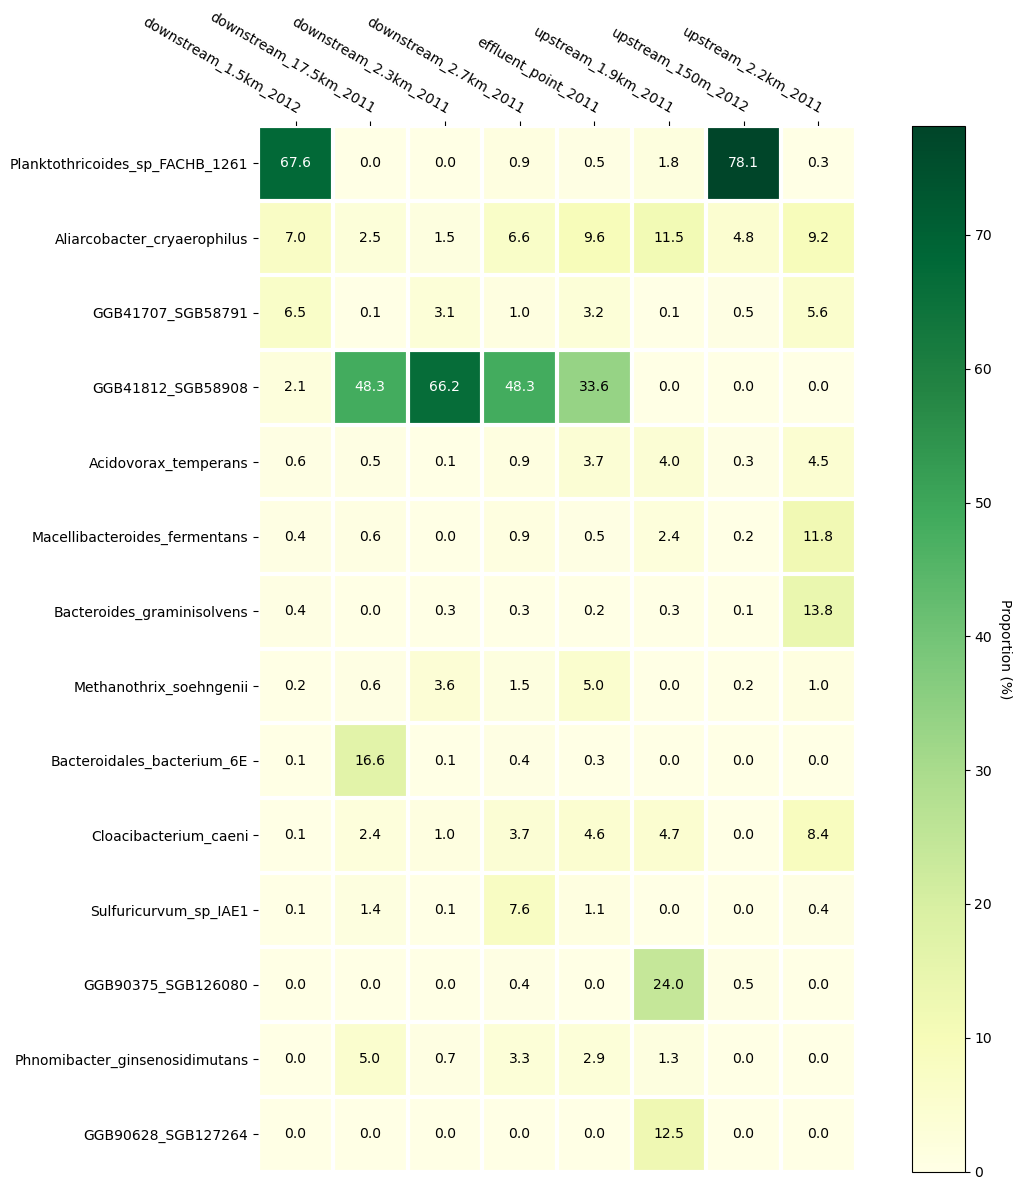

In [13]:
# Create the arrays for the functions to use

imp_species_scaled_df = species_scaled_df.loc[:, species_scaled_df.sum()>10]

imp_heatmap_df = imp_species_scaled_df.transpose()
#test_heatmap_df = species_scaled_df.iloc[:,0:20].transpose()

samples = imp_heatmap_df.index # y axis
species = imp_heatmap_df.columns # x axis
proportion = np.array(imp_heatmap_df) # value in cell

#ref https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
plt.rcParams['figure.figsize'] = [12, 12]

fig, ax = plt.subplots()

im, cbar = heatmap(proportion, samples, species, ax=ax, #todo Dubbelkolla ordning
                   cmap="YlGn", cbarlabel="Proportion (%)")
texts = annotate_heatmap(im, valfmt="{x:.1f}") #todo Where the values are rounded 

fig.tight_layout()
plt.show()

In [14]:
#PCA

In [15]:
#species_scaled_df

imp_species_scaled_df

clade_name,Planktothricoides_sp_FACHB_1261,Aliarcobacter_cryaerophilus,GGB41707_SGB58791,GGB41812_SGB58908,Acidovorax_temperans,Macellibacteroides_fermentans,Bacteroides_graminisolvens,Methanothrix_soehngenii,Bacteroidales_bacterium_6E,Cloacibacterium_caeni,Sulfuricurvum_sp_IAE1,GGB90375_SGB126080,Phnomibacter_ginsenosidimutans,GGB90628_SGB127264
downstream_1.5km_2012,67.567794,7.019982,6.477832,2.113971,0.559640,0.449220,0.375690,0.243390,0.149350,0.112620,0.069860,0.039760,0.000000,0.000000
downstream_17.5km_2011,0.000000,2.471096,0.099680,48.286468,0.498721,0.636031,0.000000,0.587351,16.648007,2.404205,1.416393,0.000000,4.998021,0.000000
downstream_2.3km_2011,0.027040,1.490232,3.068874,66.248143,0.123700,0.045450,0.277020,3.641655,0.063680,0.962421,0.100360,0.032320,0.659921,0.000000
downstream_2.7km_2011,0.919350,6.555089,1.032720,48.314722,0.921890,0.930630,0.281620,1.455360,0.411060,3.729599,7.553099,0.357480,3.255729,0.000000
effluent_point_2011,0.483759,9.618679,3.224156,33.562431,3.694176,0.510869,0.244600,4.993134,0.298280,4.600605,1.122459,0.000000,2.904027,0.000000
upstream_1.9km_2011,1.805045,11.545031,0.122590,0.035430,3.955701,2.408756,0.297221,0.041200,0.000000,4.668803,0.000000,24.018085,1.310924,12.492954
upstream_150m_2012,78.131502,4.801341,0.507670,0.000000,0.348570,0.247540,0.125310,0.199930,0.008290,0.046970,0.000000,0.502100,0.000000,0.000000
upstream_2.2km_2011,0.300850,9.190286,5.645158,0.037960,4.462878,11.804025,13.784094,1.035220,0.000000,8.376926,0.352570,0.000000,0.019640,0.000000


In [16]:
#sns.pairplot(species_df, hue='upstream_2.2km_2011')
#seaborn.pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

## Species Count

In [17]:
count_species = "species_count.txt"
# Tab separated, first row column names, first column row names
count_species = pd.read_csv("species_count.txt", sep='\t', header=0)

# Extract only the rows from 2011
count_species_2011 = count_species.loc[count_species['year'] == 2011]

min_read_amount = count_species.read_amount.min()

count_species['scaled_read'] = count_species.read_amount/min_read_amount
count_species['scaled_species_count'] = count_species.species_count / count_species.scaled_read
count_species

,Sample,species_count,type,year,read_amount,scaled_read,scaled_species_count
0,downstream_1.5km,78,downstream,2012,34776607,1.412411,55.224703
1,downstream_17.5km,44,downstream,2011,33575959,1.363648,32.266380
2,downstream_2.3km,65,downstream,2011,25647080,1.041626,62.402418
3,downstream_2.7km,91,downstream,2011,66647064,2.706793,33.619121
4,effluent_point,93,effluent,2011,24622151,1.000000,93.000000
5,upstream_1.9km,77,upstream,2011,52915463,2.149100,35.828953
6,upstream_150m,84,upstream,2012,33902189,1.376898,61.006700
7,upstream_2.2km,125,upstream,2011,42785617,1.737688,71.934661


In [18]:
# Apply the default theme
sns.set_theme()
sns.set_style("whitegrid") #todo Example

#sns.catplot(data=count_species, kind="bar", x="Sample", y="species_count", hue="type")
#plt.xticks(rotation=90)
#sns.catplot(data=count_species, kind="bar", x="Sample", y="scaled_species_count", hue="type")
#plt.xticks(rotation=90)
#sns.catplot(data=count_species, kind="bar", x="type", y="species_count")
#sns.catplot(data=count_species, kind="bar", x="type", y="scaled_species_count")
#sns.pairplot(data=count_species, hue="type")

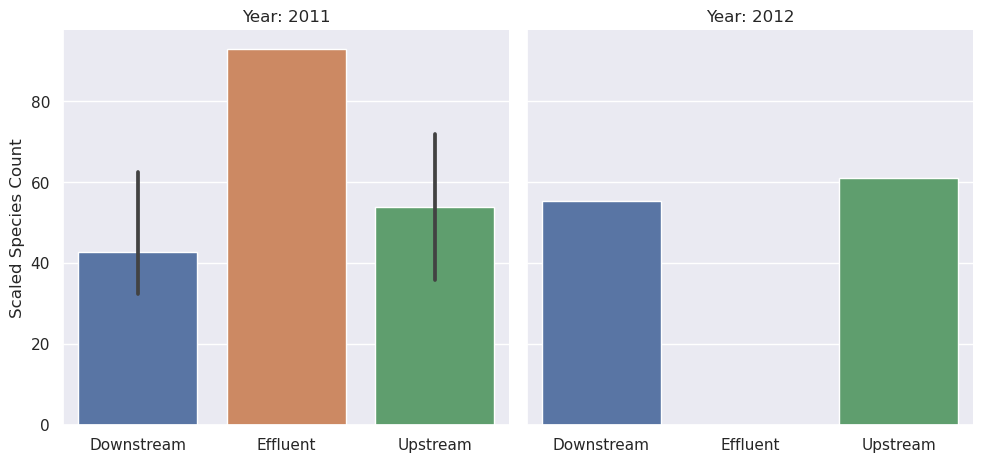

In [19]:
# Apply the default theme
sns.set_theme()
#sns.set_style("whitegrid") 
#todo Example:
#sns.set_palette("colorblind")
#sns.set_palette("pastel")
#sns.set_palette("light:b")
#sns.set_palette("light:forestgreen")
#sns.set_palette("dark:g_r")

#sns.color_palette("light:b", as_cmap=True)

g = sns.catplot(data=count_species, kind="bar", 
                x="type", y="scaled_species_count", 
                col="year")
g.set_axis_labels("", "Scaled Species Count")
g.set_xticklabels(["Downstream", "Effluent", "Upstream"])
g.set_titles("Year: {col_name}")

In [20]:
count_species


,Sample,species_count,type,year,read_amount,scaled_read,scaled_species_count
0,downstream_1.5km,78,downstream,2012,34776607,1.412411,55.224703
1,downstream_17.5km,44,downstream,2011,33575959,1.363648,32.266380
2,downstream_2.3km,65,downstream,2011,25647080,1.041626,62.402418
3,downstream_2.7km,91,downstream,2011,66647064,2.706793,33.619121
4,effluent_point,93,effluent,2011,24622151,1.000000,93.000000
5,upstream_1.9km,77,upstream,2011,52915463,2.149100,35.828953
6,upstream_150m,84,upstream,2012,33902189,1.376898,61.006700
7,upstream_2.2km,125,upstream,2011,42785617,1.737688,71.934661


In [21]:
with open ('pca_data.txt', 'w') as file:
    file.write(species_scaled_df.to_string(index=True, header=True))